# Proceso  de EDA para estudiar los datos, y preparacion para hacer un modelo de recomendacion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split as train_test_splitSV
from sklearn.preprocessing import LabelEncoder
import pickle
from surprise import SVD
from surprise.model_selection import GridSearchCV
from surprise import accuracy
from sklearn.metrics.pairwise import cosine_similarity


## Steam Games

In [2]:
steam_games = pd.read_csv('../datasets/steam_games.csv')

In [3]:
steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27834 entries, 0 to 27833
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   app_name                   27834 non-null  object 
 1   price                      27834 non-null  float64
 2   id                         27834 non-null  int64  
 3   developer                  27834 non-null  object 
 4   Accounting                 27834 non-null  int64  
 5   Action                     27834 non-null  int64  
 6   Adventure                  27834 non-null  int64  
 7   Animation &amp; Modeling   27834 non-null  int64  
 8   Audio Production           27834 non-null  int64  
 9   Casual                     27834 non-null  int64  
 10  Design &amp; Illustration  27834 non-null  int64  
 11  Early Access               27834 non-null  int64  
 12  Education                  27834 non-null  int64  
 13  Free to Play               27834 non-null  int

In [4]:
steam_games[['price','Year']].describe()
## El año va entre 1989 y 2021

,price,Year
count,27834.000000,27820.000000
mean,8.947923,2014.853810
std,15.996668,3.275912
min,0.000000,1983.000000
25%,2.990000,2014.000000
50%,4.990000,2016.000000
75%,9.990000,2017.000000
max,995.000000,2021.000000


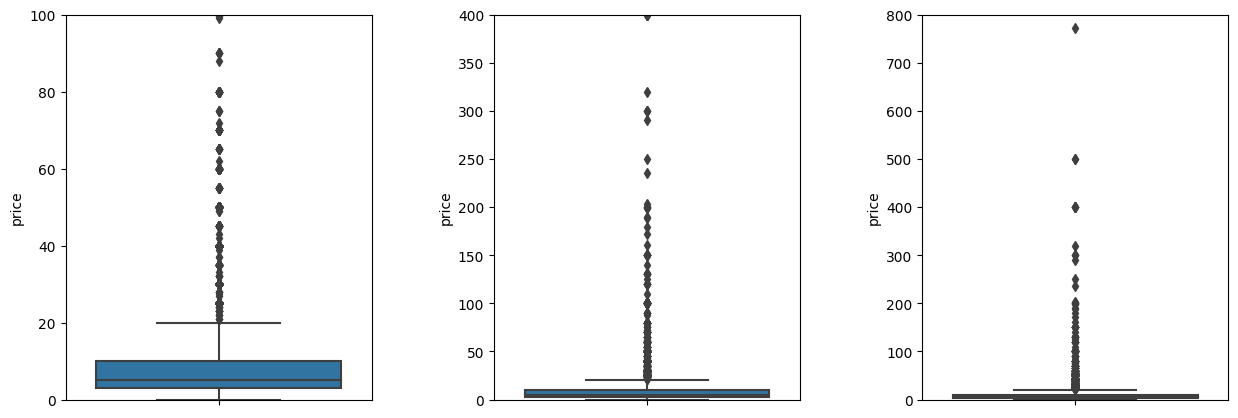

In [5]:

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data=steam_games, y='price', ax=ax[0])
sns.boxplot(data=steam_games, y='price', ax=ax[1])
sns.boxplot(data=steam_games, y='price', ax=ax[2])
ax[0].set_ylim(0, 100)
ax[1].set_ylim(0, 400)
ax[2].set_ylim(0, 800)

plt.subplots_adjust(wspace=0.4)
plt.show()


### En el grafico se puede ver que la columna price tiene muchos valores atipicos que superan los 20 y llegan a los 1000, sin embargo en una app de juegos es posible tener tal distribucion, es decir muchos juegos de precio bajo y varios de precio alto por esto no se hara un tratado especial

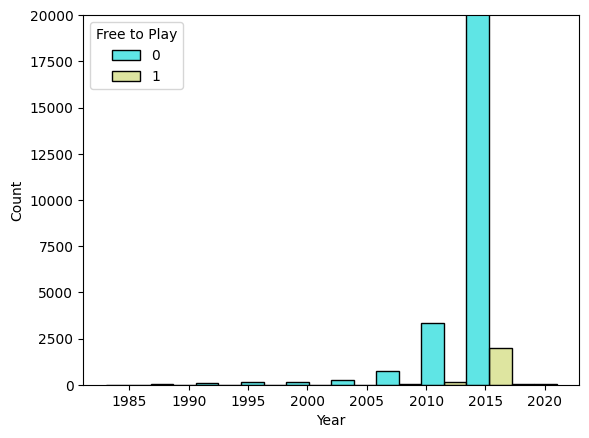

In [6]:
sns.histplot(data=steam_games,x='Year',hue='Free to Play',bins=10,palette='rainbow',multiple='dodge')

plt.ylim(0,20000)
plt.show()

### 2015 es el año con mas juegos y mas juegos Free To Play

## Users Reviews

In [7]:
user_review = pd.read_csv('../datasets/user_reviews.csv')

In [8]:
user_review.sample(5)

,user_id,posted,item_id,recommend,sentiment_analysis
21010,76561198013600577,"Posted November 1, 2012.",70310,True,1
26185,CaridoidCombatClaw,"Posted May 20, 2015.",270170,True,2
42248,ryobi_samurai,"Posted January 4, 2014.",25890,True,1
21882,76561198068441529,"Posted September 17, 2015.",351290,True,2
36629,chrisbooth,"Posted July 29, 2015.",316010,True,2


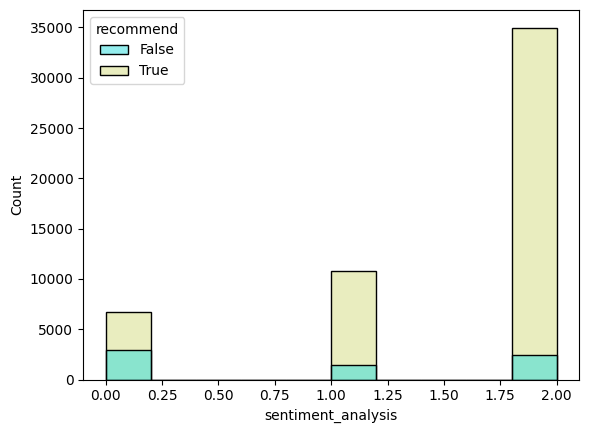

In [9]:
sns.histplot(data=user_review,x='sentiment_analysis',bins=10,palette='rainbow',hue='recommend')

plt.show()

### Como se ve del total de sentimiento malos, un alto porcentaje son recomendaciones falsas, y de los buenos el total de recomendaciones true son altas, Para ambas hay un porcentaje existente de recomendaciones que parecen opuesta al sentimiento

## Users Items

In [10]:
with gzip.open('../datasets/user_items_proc.csv.gz', 'rb') as f:
    user_items_proc = pd.read_csv(f, encoding='utf-8')

In [11]:
user_items_proc.sample(5)

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
2041958,furryfoxes,242,76561198074405870,http://steamcommunity.com/id/furryfoxes,204300.0,Awesomenauts,1834.0,0.0
89650,76561197992910116,184,76561197992910116,http://steamcommunity.com/profiles/76561197992...,12110.0,Grand Theft Auto: Vice City,335.0,0.0
3395155,jackdtimes3,270,76561198039738191,http://steamcommunity.com/id/jackdtimes3,48240.0,Anno 2070,66.0,0.0
1274670,Michael__James,675,76561198059105056,http://steamcommunity.com/id/Michael__James,418070.0,Turbo Pug,418.0,0.0
702350,76561198082939654,181,76561198082939654,http://steamcommunity.com/profiles/76561198082...,47780.0,Dead Space 2,0.0,0.0


In [12]:
user_items_proc['playtime_forever'].describe()

count    5.153209e+06
mean     9.914951e+02
std      5.418204e+03
min      0.000000e+00
25%      0.000000e+00
50%      3.400000e+01
75%      3.550000e+02
max      6.427730e+05
Name: playtime_forever, dtype: float64

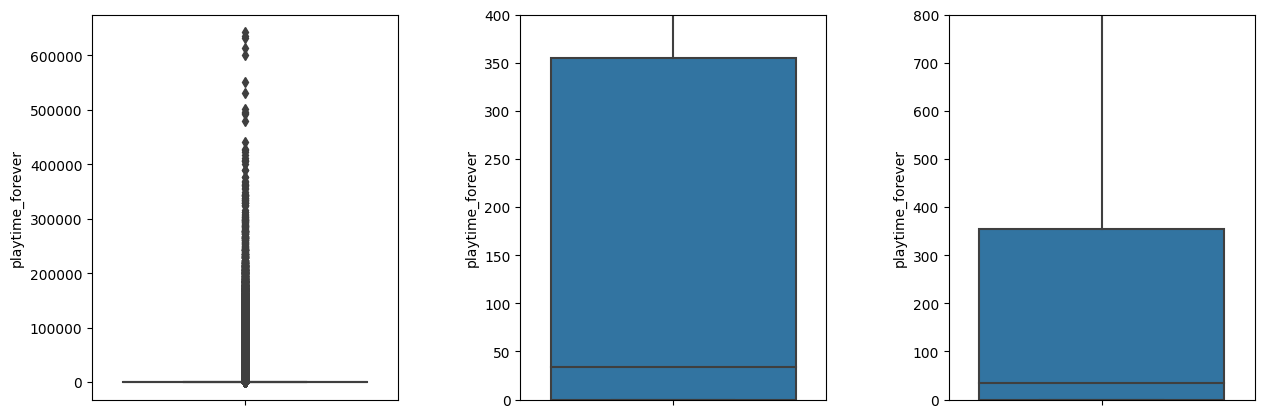

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data=user_items_proc, y='playtime_forever', ax=ax[0])
sns.boxplot(data=user_items_proc, y='playtime_forever', ax=ax[1])
sns.boxplot(data=user_items_proc, y='playtime_forever', ax=ax[2])
ax[1].set_ylim(0, 400)
ax[2].set_ylim(0, 800)

plt.subplots_adjust(wspace=0.4)
plt.show()


### Hay valores atipicos de playtime_forever pero solo se hara un tratado si se encuentra un valor que supere la cantidad de minutos entre que salio el juego y la fecha actual.

In [14]:

# Agregando los comentarios explicativos
# Unimos los dataframes 'steam_games' y 'user_items_proc' basado en 'id' y 'item_id' respectivamente.
games_users = pd.merge(steam_games[['id','Year']], user_items_proc[['item_id','playtime_forever']], left_on='id', right_on='item_id', how='inner')

# Buscamos los valores erróneos en la columna 'playtime_forever' donde el tiempo de juego es mayor que la edad del juego en minutos
# Suponemos que cada año tiene 365 días, cada día 24 horas, cada hora 60 minutos
valores_playtime_erroneos = games_users[(2021 - games_users['Year'])*365*24*60 < games_users['playtime_forever']]

valores_playtime_erroneos # Como se ve es vacio, significa que no hay valores erróneos.
valores_playtime_erroneos # Como se ve es vacio.

,id,Year,item_id,playtime_forever


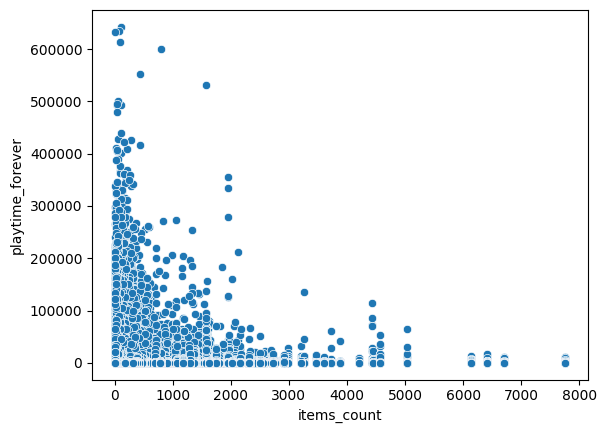

In [15]:
sns.scatterplot(data=user_items_proc,x='items_count',y='playtime_forever')
plt.show()

### Se podria analisar de forma que a menos cantidad de items mas tiempo consume un usuario un juego especifico.

In [16]:
playtime_poritem = user_items_proc.groupby('item_id')['playtime_forever'].sum().div(60).reset_index()
playtime_poritem
games_playtime = pd.merge(steam_games,playtime_poritem,left_on='id',right_on='item_id',how='inner')
games_playtime.sample(5)

,app_name,price,id,developer,Accounting,Action,Adventure,Animation &amp; Modeling,Audio Production,Casual,...,Simulation,Software Training,Sports,Strategy,Utilities,Video Production,Web Publishing,Year,item_id,playtime_forever
5551,Planet Alcatraz 2,4.99,389250,1C Company,0,0,1,0,0,0,...,0,0,0,0,0,0,0,2008.0,389250.0,9.433333
5420,Lumini,12.99,360840,Speelbaars,0,0,1,0,0,0,...,1,0,0,0,0,0,0,2015.0,360840.0,9.500000
4081,BomberZone,1.99,473140,Dracula Bytes,0,1,0,0,0,1,...,0,0,0,0,0,0,0,2016.0,473140.0,17.733333
4890,Gnumz: Masters of Defense,4.99,371460,Creobit,0,0,0,0,0,1,...,0,0,0,1,0,0,0,2015.0,371460.0,100.900000
3253,Cubway,3.99,511160,Armnomads LLC,0,1,1,0,0,0,...,0,0,0,0,0,0,0,2016.0,511160.0,0.383333


In [17]:
# Ordena el DataFrame 'games_playtime' en orden descendente por la columna 'playtime_forever'
games_playtime.sort_values(ascending=False,by='playtime_forever',inplace=True)

# Selecciona las primeras 15 filas después de ordenar y los almacena en 'best_hours15'
best_hours15 = games_playtime.head(15)

# Muestra las primeras 5 filas de 'best_hours15'
best_hours15.head(5)

,app_name,price,id,developer,Accounting,Action,Adventure,Animation &amp; Modeling,Audio Production,Casual,...,Simulation,Software Training,Sports,Strategy,Utilities,Video Production,Web Publishing,Year,item_id,playtime_forever
601,Counter-Strike: Global Offensive,14.99,730,Valve,0,1,0,0,0,0,...,0,0,0,1,0,0,0,2012.0,730.0,1.308640e+07
8,Garry's Mod,9.99,4000,Facepunch Studios,0,1,1,0,0,0,...,1,0,0,0,0,0,0,2006.0,4000.0,7.472777e+06
7990,Terraria,9.99,105600,Re-Logic,0,1,1,0,0,0,...,0,0,0,0,0,0,0,2011.0,105600.0,2.582909e+06
7634,Warframe,0.00,230410,Digital Extremes,0,1,0,0,0,0,...,0,0,0,0,0,0,0,2013.0,230410.0,2.067128e+06
8507,Counter-Strike: Source,19.99,240,Valve,0,1,0,0,0,0,...,1,0,0,1,0,0,0,2004.0,240.0,1.876867e+06


### A partir del dataframe con la los rangink de juegos por horas jugadas voy a graficar

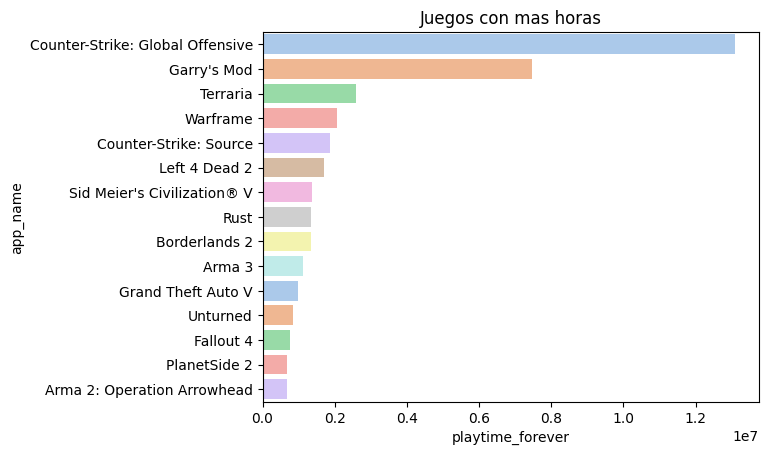

In [18]:
sns.barplot(data=best_hours15,y='app_name',x='playtime_forever',palette='pastel')
plt.title('Juegos con mas horas')
plt.show()

### Ahora voy a grupar por developer

In [19]:
# Agrupar los datos por 'developer' y calcular la suma de 'playtime_forever'.
games_playtime_dev = games_playtime.groupby('developer')['playtime_forever'].sum().reset_index()

# Ordenar los datos en orden descendente por 'playtime_forever'.
games_playtime_dev.sort_values(ascending=False,by='playtime_forever',inplace=True)

# Seleccionar los 15 'developer' con más tiempo de juego acumulado.
best_games_playtime_dev = games_playtime_dev.head(15)

# Mostrar los primeros 5 'developer' con más tiempo de juego.
best_games_playtime_dev.head(5)

,developer,playtime_forever
5070,Valve,1.824512e+07
1671,Facepunch Studios,8.824784e+06
3843,Re-Logic,2.582909e+06
672,Bohemia Interactive,2.445825e+06
1334,Digital Extremes,2.079624e+06


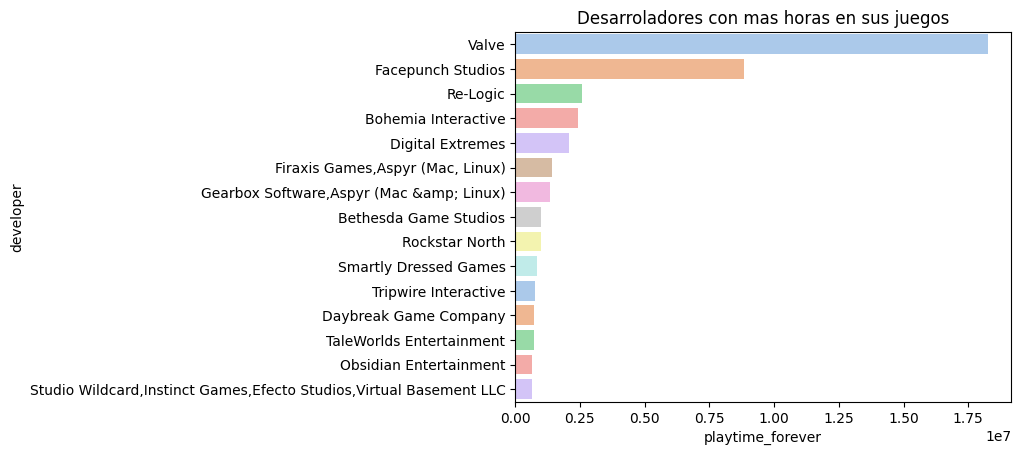

In [20]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Here sns.barplot function is used for representing some data in an informative way.
# Data for our graph is taken from best_games_playtime_dev dataset.
# The y axis represents developers while the x axis represents playtime forever.
sns.barplot(data=best_games_playtime_dev,y='developer',x='playtime_forever',palette='pastel')

# Set the title for our graph.
plt.title('Desarroladores con mas horas en sus juegos')

# Displaying the final graph.
plt.show()

### Ahora a partir de user_review voy a sumar la cantidad de recomendaciones positivas.


In [21]:
# Agrupamos las reseñas de usuarios por 'item_id' y aplicamos una transformación de 'recommend'
user_review_cop = user_review
user_review_cop['recommend'] = user_review['recommend'].apply(lambda x:1 if x else -1) # Recomendaciones positivas suma y negativas resta
user_review_rec = user_review_cop.groupby('item_id')['recommend'].sum().reset_index()

# Unimos los dataframes 'steam_games' y 'user_review_rec' en la columna 'id' e 'item_id', respectivamente
games_recommend = pd.merge(steam_games,user_review_rec,left_on='id',right_on='item_id',how='inner')

# Agregamos las recomendaciones por desarrollador
games_recommend = games_recommend.groupby('developer')['recommend'].sum().reset_index()

# Ordenamos los valores en orden descendente para obtener los mejores recomendados
games_recommend.sort_values(ascending=False,by='recommend',inplace=True) # Obtengo las mejores recomendaciones

# Tomamos los primeros 15 resultados
games_recommend_best = games_recommend.head(15)

# Mostramos los primeros 5 resultados
games_recommend_best.head(5)

,developer,recommend
1936,Valve,8728
639,Facepunch Studios,2224
1628,Smartly Dressed Games,888
250,Bohemia Interactive,749
1433,Re-Logic,705


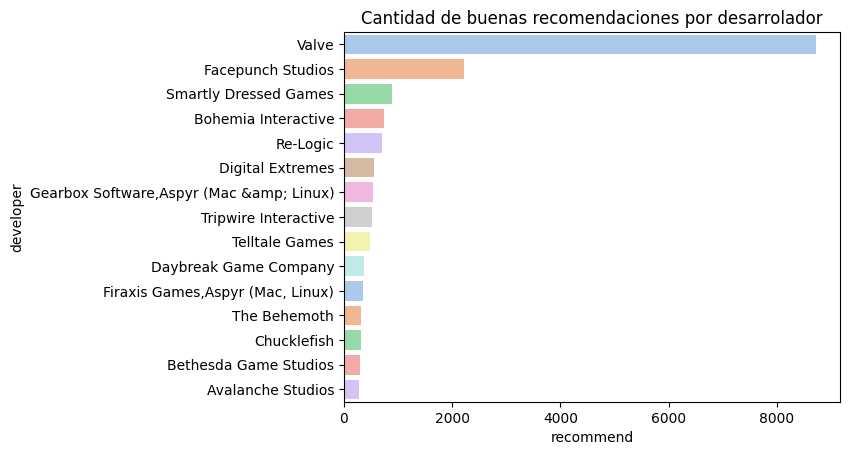

In [22]:
sns.barplot(data=games_recommend_best,x='recommend',y='developer',palette='pastel')
plt.title('Cantidad de buenas recomendaciones por desarrolador')
plt.show()

# Modelo de recomendacion

### Cargo el dataset usado para el modelo

In [46]:
user_reviews = pd.read_csv('../datasets/user_reviews.csv',usecols=['user_id','item_id','sentiment_analysis','recommend'])
label_encoder = LabelEncoder()
#elimino la columna user_id
user_reviews['user_id_num'] = label_encoder.fit_transform(user_reviews['user_id'])



### Voy a generar un rating a partir de recommend y sentiment_analysis para que este entre 0 y 5

In [47]:
"""for index, row in user_reviews.iterrows():
    if (row[2] == 1) and (row[3] == 2):
        user_reviews.at[index, 'rating'] = 3
    elif (row[2] == 1) and (row[3] == 1):
        user_reviews.at[index, 'rating'] = 2
    elif (row[2] == 1) and (row[3] == 0):
        user_reviews.at[index, 'rating'] = 1
    elif (row[2] == 0) and (row[3] == 2):
        user_reviews.at[index, 'rating'] = 2
    elif (row[2] == 0) and (row[3] == 1):
        user_reviews.at[index, 'rating'] = 1
    elif (row[2] == 0) and (row[3] == 0):
        user_reviews.at[index, 'rating'] = 0"""

"for index, row in user_reviews.iterrows():\n    if (row[2] == 1) and (row[3] == 2):\n        user_reviews.at[index, 'rating'] = 3\n    elif (row[2] == 1) and (row[3] == 1):\n        user_reviews.at[index, 'rating'] = 2\n    elif (row[2] == 1) and (row[3] == 0):\n        user_reviews.at[index, 'rating'] = 1\n    elif (row[2] == 0) and (row[3] == 2):\n        user_reviews.at[index, 'rating'] = 2\n    elif (row[2] == 0) and (row[3] == 1):\n        user_reviews.at[index, 'rating'] = 1\n    elif (row[2] == 0) and (row[3] == 0):\n        user_reviews.at[index, 'rating'] = 0"

In [48]:
user_reviews['rating'] = np.where(user_reviews['recommend'] == True,  # Si 'recommend' es True
                                 np.where(user_reviews['sentiment_analysis'] == 2, 5,  # Si 'sentimiento' es positivo
                                          np.where(user_reviews['sentiment_analysis'] == 1, 3,  # Si 'sentimiento' es neutro
                                                   1)),  # Si 'sentimiento' es negativo cuando 'recommend' es True
                                 np.where(user_reviews['sentiment_analysis'] == 2, 4,  # Si 'sentimiento' es positivo
                                          np.where(user_reviews['sentiment_analysis'] == 1, 2,  # Si 'sentimiento' es neutro
                                                   0)))  # Si 'sentimiento' es negativo cuando 'recommend' es False

In [49]:
user_reviews.sample(5)

,user_id,item_id,recommend,sentiment_analysis,user_id_num,rating
50605,76561198063055125,239070,True,2,5348,5
53520,76561198076114293,17460,True,2,7647,5
46727,newhollandarmy,223470,True,1,22668,3
46078,76561198024028497,227100,False,0,1647,0
53714,TheMarshmallowMan101,730,True,2,17361,5


In [50]:
print(user_reviews['rating'].max())
print(user_reviews['rating'].min())

5
0


### Genero id numericos para user_id usando label encoder

In [51]:
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(user_reviews[['user_id_num','item_id','rating']], reader)


### Separo el dataset en entrenamiento y testeo

In [52]:
train,test = train_test_splitSV(data,test_size = .25)

## Voy a usar un modelo De descomposicion en valor singular (SVD), el cual es un filtro colaborativo
### Voy a usar los datos de 
* user_id
* item_id
* sentiment_analysis: como rating

### Aplico GridSearch para encontrar al modelo con los mejores hiperparametros

In [53]:
param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)


In [54]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])
best_model = gs.best_estimator['rmse']

1.5840100111706839
{'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}


### Veo que el modelo tiene un rmse de 1.06 lo cual esta cerca de 1lo cual en la escala esta bien
### Ademas veo los mejores hiperparametros

## Por ultimo defino el modelo con los mejores hiperparametros y lo exporto

In [55]:
model = SVD(n_factors=100,n_epochs=20,lr_all=0.005,reg_all=0.2)
model.fit(train)

In [56]:
from surprise import accuracy
train_predictions = model.test(train.build_testset())
test_predictions = model.test(test)
print(f"RMSE en el conjunto de entrenamiento: {accuracy.rmse(train_predictions)}")
print(f"RMSE en el conjunto de prueba: {accuracy.rmse(test_predictions)}")

RMSE: 1.2764
RMSE en el conjunto de entrenamiento: 1.2764039278981176
RMSE: 1.5817
RMSE en el conjunto de prueba: 1.5817043122021668


### EL modelo obtuvo un mejor rendimiento en los datos de testeo el rmse 1.5 me indica que en en el ranking de 0 5 lo que indica una desviacion de 1.5 si bien tiene mucho rango de mejora para las columnas usadas como rating esta bastante bien

In [57]:
with open('./SVD_model.pkl', 'wb') as file: # Exporto mi modelo
    pickle.dump(model, file)

In [58]:
print(model.predict(4124,12354))
print(model.predict(4124,1244))
print(model.predict(4124,154))
print(model.predict(4124,12554))
print(model.predict(4124,1213))
print(model.predict(4124,1884))
print(model.predict(4124,35354))
print(model.predict(4124,1324))
print(model.predict(4124,13224))


user: 4124       item: 12354      r_ui = None   est = 3.82   {'was_impossible': False}
user: 4124       item: 1244       r_ui = None   est = 3.82   {'was_impossible': False}
user: 4124       item: 154        r_ui = None   est = 3.82   {'was_impossible': False}
user: 4124       item: 12554      r_ui = None   est = 3.82   {'was_impossible': False}
user: 4124       item: 1213       r_ui = None   est = 3.82   {'was_impossible': False}
user: 4124       item: 1884       r_ui = None   est = 3.82   {'was_impossible': False}
user: 4124       item: 35354      r_ui = None   est = 3.82   {'was_impossible': False}
user: 4124       item: 1324       r_ui = None   est = 3.82   {'was_impossible': False}
user: 4124       item: 13224      r_ui = None   est = 3.82   {'was_impossible': False}


## A contuacion hare un modelo basado en 
* Para esto usare la tabla steam_games y los generos de los juegos

In [92]:
def item_rec(app_name:int):
    generos = list(steam_games.drop(columns=['app_name','price','id','developer','Accounting','Year']).columns)
    generos
    perfiles_items = []
    for _, row in steam_games.iterrows():
        perfil_item = []
        for genero in generos:
            perfil_item.append(row[genero])
        perfiles_items.append(perfil_item)

    perfiles_items_df = pd.DataFrame(perfiles_items, columns=generos)
    perfiles_items_df['app_name'] = steam_games['app_name']
    perfiles_items_df['id'] = steam_games['id']

    # Nombre de la aplicación para la cual deseas obtener recomendaciones
    if app_name not in list(steam_games['id']):
        return 'EL item no se a podido encontrar'

    # Encuentra el índice correspondiente al nombre de la aplicación
    app_index = perfiles_items_df[perfiles_items_df['id'] == app_name].index[0]
    perfiles_items_array = perfiles_items_df.drop(columns=['app_name','id']).values
    # Obtén el perfil de la aplicación del DataFrame
    app_profile = perfiles_items_array[app_index].reshape(1, -1)

    # Calcula la similitud de coseno entre el perfil de la aplicación y todos los perfiles de items
    similarity_scores = cosine_similarity(app_profile, perfiles_items_array)

    # Ordena los juegos por similitud y toma los primeros 5 juegos recomendados
    recommended_games = np.argsort(similarity_scores[0])[::-1][:5]

    # Obtiene los índices de los juegos recomendados en el DataFrame original
    recommended_game_indices = perfiles_items_df.index[recommended_games]

    # Obtiene los nombres de los juegos recomendados
    recommended_game_names = perfiles_items_df.loc[recommended_game_indices, 'app_name']
    return {
        'Recomendacion 1':recommended_game_names.iloc[0],
        'Recomendacion 2':recommended_game_names.iloc[1],
        'Recomendacion 3':recommended_game_names.iloc[2],
        'Recomendacion 4':recommended_game_names.iloc[3],
        'Recomendacion 5':recommended_game_names.iloc[4]
            }


In [93]:
item_rec(658870)

{'Recomendacion 1': 'EXIT 2 - Directions',
 'Recomendacion 2': 'Keep Rollin!',
 'Recomendacion 3': 'Tetropunk',
 'Recomendacion 4': "Alexa's Wild Night",
 'Recomendacion 5': 'Zup! 7 - 4:3 Pack'}